In [1]:
import os
os.environ['PROJ_DATA'] = r'C:\Users\Dan\micromamba\envs\geopython2025\Library\share\proj'
os.environ['PROJ_LIB'] = r'C:\Users\\Dan\micromamba\envs\geopython\Library\share\proj'

In [2]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
import matplotlib.pyplot as plt
from shapely.ops import nearest_points
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
import mapclassify
import matplotlib.colors as mcolors
from mapclassify import NaturalBreaks
import contextily as ctx
from networkx import ego_graph
from shapely.geometry import box

In [4]:
tqdm.pandas()

In [5]:
# 1. impordin andmed
df = pd.read_csv("split_prices.csv") 
gdf_rent = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf_rent = gdf_rent.to_crs(epsg=3301)


In [6]:
# Kogun Tartu linna andmed openstreetmapist
place_name = "Tartu, Estonia"
gdf_place = ox.geocode_to_gdf(place_name)
polygon = gdf_place.geometry.iloc[0]


In [7]:
# Teede võrgu koostamine
G = ox.graph_from_polygon(polygon, network_type='walk')
G = ox.project_graph(G, to_crs='EPSG:3301')  # koordinaatsüsteemide ühildamine

In [8]:
# Defineerin teenuste grupid

amenity_groups = {
    "food": ["restaurant", "cafe", "fast_food", "bar", "pub", "ice_cream"],
    "health": ["hospital", "clinic", "doctors", "dentist", "pharmacy", "veterinary"],
    "education": ["school", "kindergarten", "university", "college", "library"],
    "transport": ["bus_station", "taxi", "parking", "bicycle_parking", "car_rental"],
    "services": ["bank", "atm", "post_office", "hairdresser", "beauty"],
    "public": ["townhall", "police", "fire_station", "courthouse", "prison"],
    "leisure": ["cinema", "theatre", "community_centre", "arts_centre"],
    "religion": ["place_of_worship", "grave_yard"]
}


In [9]:
# arvutab lähima tee sõlme
gdf_rent['nearest_node'] = gdf_rent.geometry.apply(lambda x: ox.distance.nearest_nodes(G, x.x, x.y))

In [10]:
# Openstreetmapi teenused
tags = {"amenity": True}
pois_all = ox.features_from_polygon(polygon, tags)
pois_all = pois_all.to_crs(gdf_rent.crs)  # Match CRS

In [11]:
points = pois_all[pois_all.geometry.type == "Point"]
polygons = pois_all[pois_all.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [12]:
# teen teenused mis on polügonid tsentroidideks
polygons_centroids = polygons.copy()
polygons_centroids["geometry"] = polygons_centroids.geometry.centroid

In [13]:
# panen teenused kokku tagasi
pois_combined = pd.concat([points, polygons_centroids])

In [14]:
pois_combined = pois_combined.reset_index(drop=True)

In [15]:
# Arvutan kaugused teenuste gruppide ja korterite vahel
for group_name, amenities in amenity_groups.items():
    print(f"\nProcessing {group_name}...")
    pois = pois_combined[pois_combined['amenity'].isin(amenities)].copy()

    if pois.empty:
        print(f" No POIs found for group '{group_name}' — skipping.")
        gdf_rent[f'dist_to_{group_name}'] = None
        continue

    print(f"  → Using {len(pois)} POIs")

    pois['node'] = pois.geometry.progress_apply(lambda x: ox.distance.nearest_nodes(G, x.x, x.y))
    amenity_nodes = pois['node'].unique().tolist()

    print(f"  → Unique POI nodes: {len(amenity_nodes)}")

    dist_dict = nx.multi_source_dijkstra_path_length(G, amenity_nodes, weight='length')

    gdf_rent[f'dist_to_{group_name}'] = gdf_rent['nearest_node'].apply(lambda node: dist_dict.get(node, None))


Processing food...
  → Using 177 POIs


100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [00:20<00:00,  8.78it/s]


  → Unique POI nodes: 143

Processing health...
  → Using 72 POIs


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:08<00:00,  8.43it/s]


  → Unique POI nodes: 65

Processing education...
  → Using 134 POIs


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:16<00:00,  8.26it/s]


  → Unique POI nodes: 128

Processing transport...
  → Using 1062 POIs


100%|██████████████████████████████████████████████████████████████████████████████| 1062/1062 [02:06<00:00,  8.38it/s]


  → Unique POI nodes: 955

Processing services...
  → Using 70 POIs


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:07<00:00,  8.81it/s]


  → Unique POI nodes: 60

Processing public...
  → Using 12 POIs


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.51it/s]


  → Unique POI nodes: 10

Processing leisure...
  → Using 12 POIs


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.40it/s]


  → Unique POI nodes: 12

Processing religion...
  → Using 19 POIs


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  8.62it/s]


  → Unique POI nodes: 19


In [16]:
gdf_rent_clean = gdf_rent.dropna(subset=['price', 'dist_to_food', 'dist_to_education',
                                         'dist_to_health','dist_to_transport',
                                         'dist_to_public', 'dist_to_religion'])

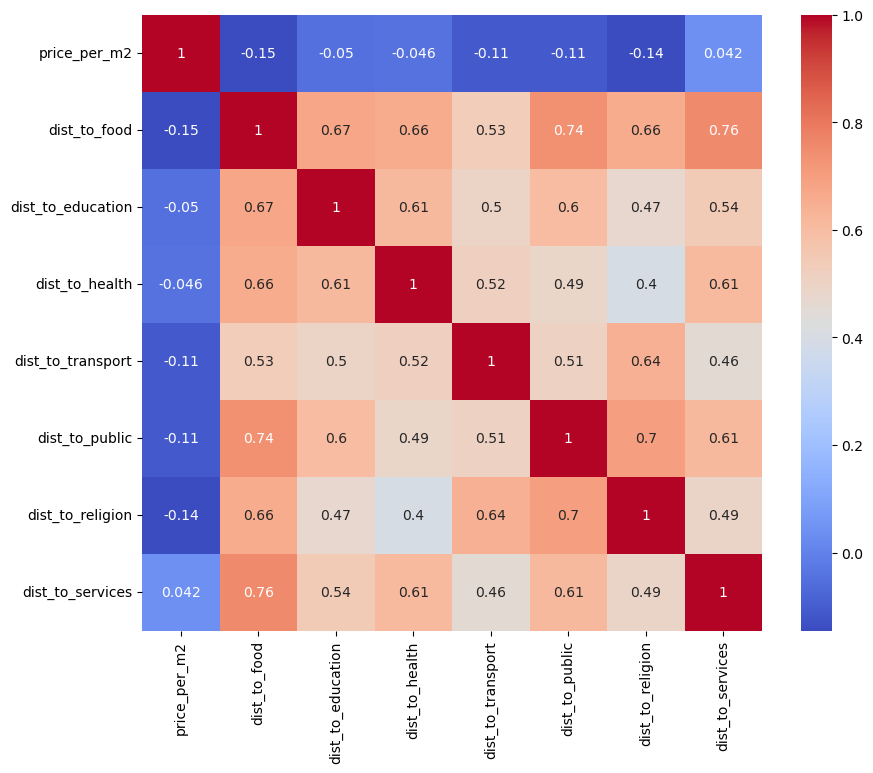

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
    
corr = gdf_rent_clean[['price_per_m2','dist_to_food', 'dist_to_education', 'dist_to_health',
                       'dist_to_transport','dist_to_public', 'dist_to_religion','dist_to_services']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')

plt.show()

In [18]:
# ei ole positiivset korrelatsiooni üürikorterite hindade ja teenuste kaugse vahel. Erinevate teenuste kauguste vahel on aga korrelatsioon, mis viitab teenuste klasterdumisele. 

In [19]:
# Andmetest kaartide loomine

In [20]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)


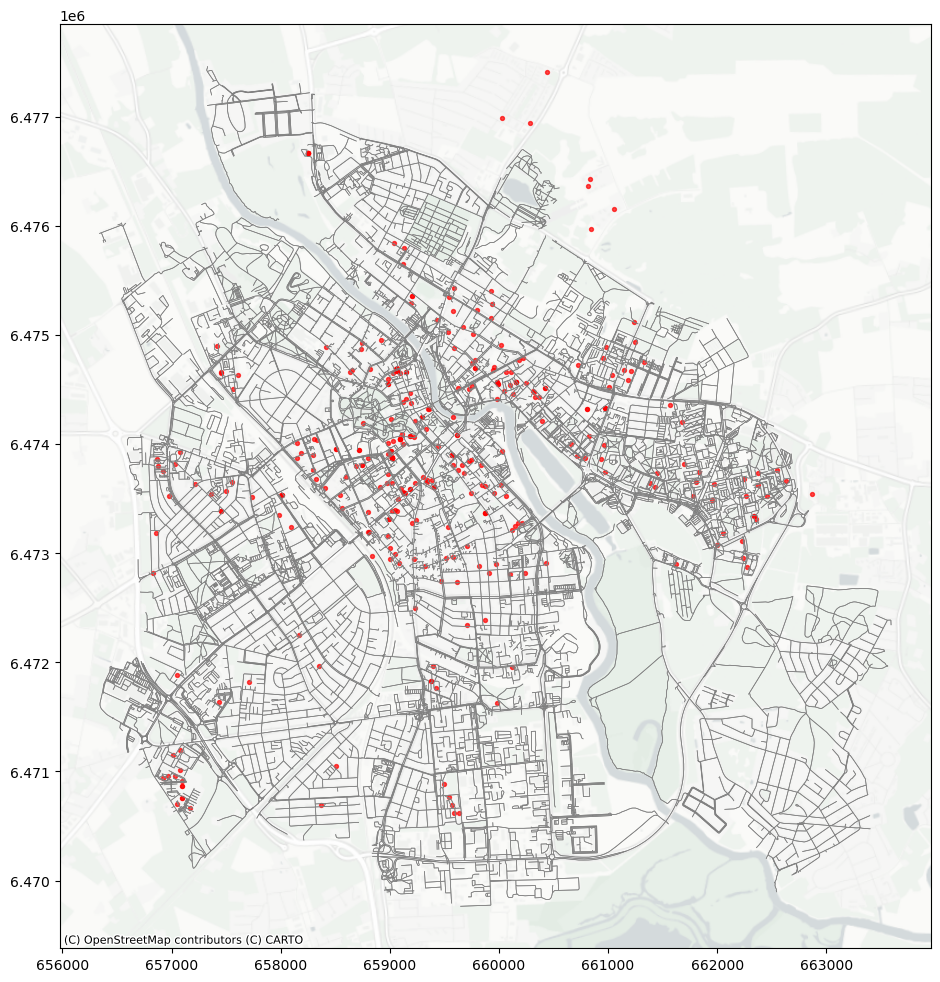

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.5, color="gray")
gdf_rent.plot(ax=ax, color="red", markersize=8, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_rent.crs)

In [22]:
#

In [23]:
# 
minx, miny, maxx, maxy = gdf_rent.total_bounds



In [24]:
grid_spacing = 10  # Try even 0.02 or 0.05 to start

x_vals = np.arange(minx, maxx, grid_spacing)
y_vals = np.arange(miny, maxy, grid_spacing)
len(x_vals), len(y_vals), len(x_vals) * len(y_vals)

(604, 679, 410116)

In [25]:
grid_points = np.array([(x, y) for x in x_vals for y in y_vals])

In [26]:
def idw_interpolation(xy_obs, values, xy_targets, power=2):
    interpolated_values = []
    for x0, y0 in xy_targets:
        distances = np.sqrt((xy_obs[:, 0] - x0)**2 + (xy_obs[:, 1] - y0)**2)
        if np.any(distances == 0):
            interpolated_values.append(values[distances == 0][0])
        else:
            weights = 1 / distances**power
            interpolated_values.append(np.sum(weights * values) / np.sum(weights))
    return np.array(interpolated_values)

In [27]:
# 
coords = np.array([(geom.x, geom.y) for geom in gdf_rent.geometry])
values = gdf_rent['price'].values

In [28]:
#
interpolated_prices = idw_interpolation(coords, values, grid_points)

In [29]:
interpolated_geoms = [Point(xy) for xy in grid_points]
gdf_interpolated = gpd.GeoDataFrame({'price': interpolated_prices}, geometry=interpolated_geoms, crs=gdf_rent.crs)

In [30]:
gdf_interpolated['bin'], bins = pd.qcut(gdf_interpolated['price'], 5, retbins=True, duplicates='drop')
gdf_interpolated['class'] = pd.qcut(gdf_interpolated['price'], 5, labels=False)

In [31]:
nb = mapclassify.NaturalBreaks(gdf_interpolated['price'], k=5)
gdf_interpolated['class'] = nb.yb 
bins = nb.bins 

In [32]:
labels = []
lower = gdf_interpolated['price'].min()
for upper in bins:
    labels.append(f"{int(lower)}–{int(upper)} €")
    lower = upper

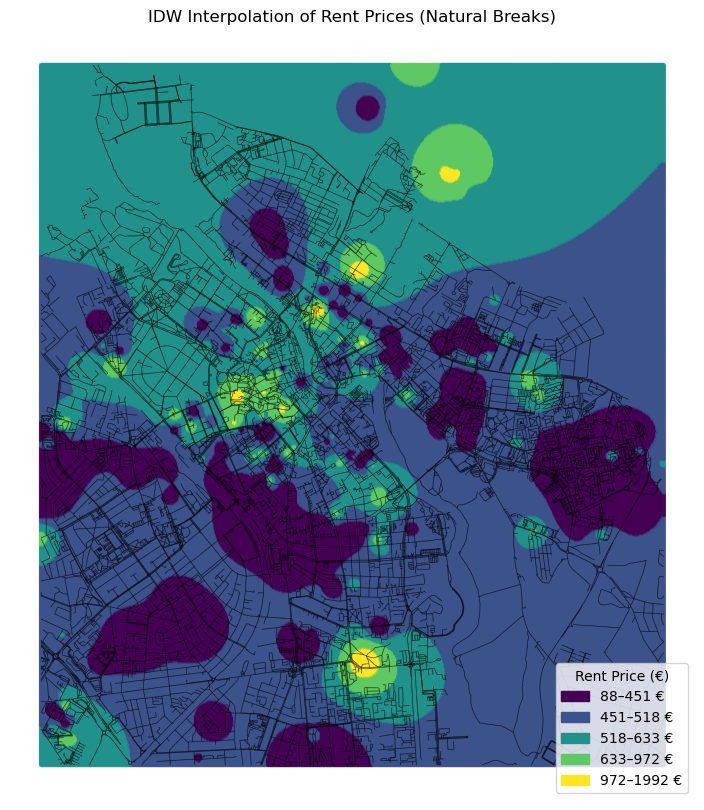

In [33]:
cmap = plt.cm.viridis
colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

minx, miny, maxx, maxy = gdf_interpolated.total_bounds
bbox = box(minx, miny, maxx, maxy)
edges_clipped = gpd.clip(edges, bbox)

fig, ax = plt.subplots(figsize=(12, 10))

gdf_interpolated.plot(column='class', ax=ax, cmap='viridis', markersize=5, alpha=0.6, legend=False)
edges_clipped.plot(ax=ax, color='black', linewidth=0.5, alpha=0.4)

ax.legend(handles=patches, title='Rent Price (€)', loc='lower right')

plt.title("IDW Interpolation of Rent Prices (Natural Breaks)")
plt.axis('off')
plt.show()

In [34]:
coords = np.array([(geom.x, geom.y) for geom in gdf_rent.geometry])
values = gdf_rent['price_per_m2'].values

In [35]:
interpolated_ppm2 = idw_interpolation(coords, values, grid_points)

In [36]:
interpolated_geoms = [Point(xy) for xy in grid_points]
gdf_ppm2 = gpd.GeoDataFrame({'ppm2': interpolated_ppm2}, geometry=interpolated_geoms, crs=gdf_rent.crs)

In [37]:
nb = mapclassify.NaturalBreaks(gdf_ppm2['ppm2'], k=5)
gdf_ppm2['class'] = nb.yb  # class labels 0–4
bins = nb.bins

In [38]:
labels = []
lower = gdf_ppm2['ppm2'].min()
for upper in bins:
    labels.append(f"{int(lower)}–{int(upper)} €/m²")
    lower = upper

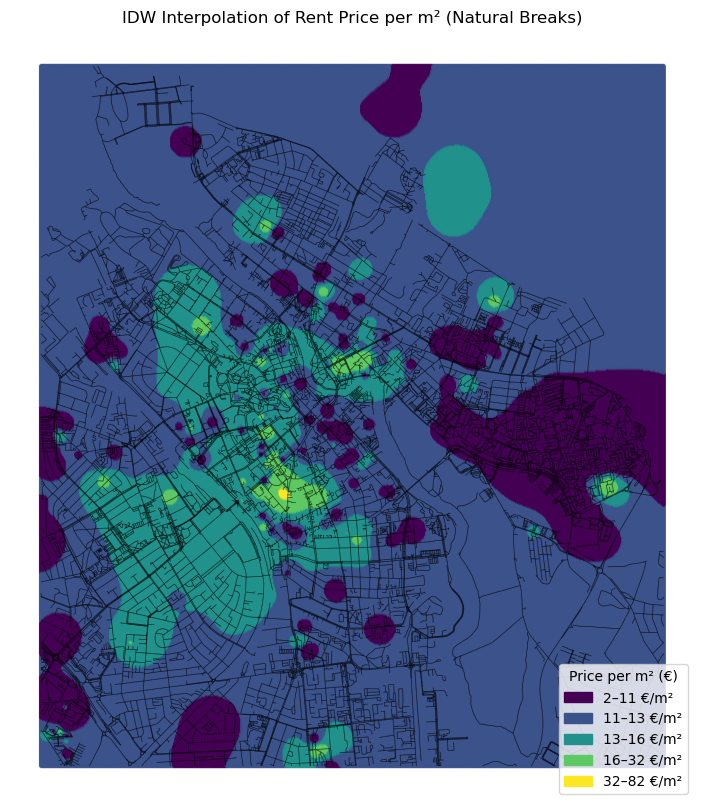

In [39]:
cmap = plt.cm.viridis
colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

fig, ax = plt.subplots(figsize=(12, 10))

gdf_ppm2.plot(column='class', ax=ax, cmap='viridis', markersize=5, alpha=0.6, legend=False)

edges_clipped.plot(ax=ax, color='black', linewidth=0.5, alpha=0.4)

ax.legend(handles=patches, title='Price per m² (€)', loc='lower right')

plt.title("IDW Interpolation of Rent Price per m² (Natural Breaks)")
plt.axis('off')

plt.savefig("rent_price_idw.png", dpi=300, bbox_inches='tight')

plt.show()

In [40]:
gdf_rent['area'] = gdf_rent['price'] / gdf_rent['price_per_m2']

In [41]:
gdf_rent = gdf_rent[gdf_rent['price_per_m2'] > 0].copy()


In [42]:
values = gdf_rent['area'].values

In [43]:
interpolated_area = idw_interpolation(coords, values, grid_points)

In [44]:
interpolated_geoms = [Point(xy) for xy in grid_points]
gdf_area = gpd.GeoDataFrame({'area': interpolated_area}, geometry=interpolated_geoms, crs=gdf_rent.crs)

In [45]:
nb = mapclassify.NaturalBreaks(gdf_area['area'], k=5)
gdf_area['class'] = nb.yb
bins = nb.bins

In [46]:
labels = []
lower = gdf_area['area'].min()
for upper in bins:
    labels.append(f"{int(lower)}–{int(upper)} m²")
    lower = upper

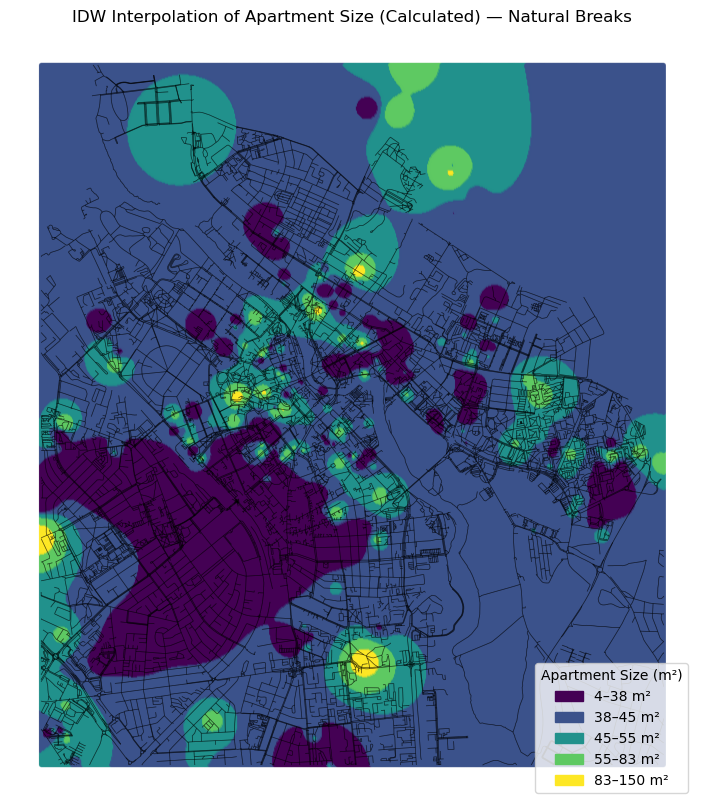

In [47]:
cmap = plt.cm.viridis
colors = [cmap(i / (len(labels) - 1)) for i in range(len(labels))]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

fig, ax = plt.subplots(figsize=(12, 10))

gdf_area.plot(column='class', ax=ax, cmap='viridis', markersize=5, alpha=0.6, legend=False)

edges_clipped.plot(ax=ax, color='black', linewidth=0.5, alpha=0.4)

ax.legend(handles=patches, title='Apartment Size (m²)', loc='lower right')

plt.title("IDW Interpolation of Apartment Size (Calculated) — Natural Breaks")
plt.axis('off')
plt.show()

In [48]:
# Loon kaardi mis näitab iga üürikorteri kaugust toidu teenustest

In [49]:
WALKING_SPEED_M_PER_MIN = 83

In [50]:
gdf_rent['walk_time_to_food'] = gdf_rent['dist_to_food'] / WALKING_SPEED_M_PER_MIN

In [51]:
avg_walk_time = gdf_rent['walk_time_to_food'].mean()
print(f"Average walking time to nearest food amenity: {avg_walk_time:.2f} minutes")

Average walking time to nearest food amenity: 4.89 minutes


In [52]:
nb = NaturalBreaks(gdf_rent['walk_time_to_food'], k=5)
gdf_rent['walk_time_class'] = nb.yb 

C:\Users\Dan\micromamba\envs\geopython2025\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [53]:
cmap = mcolors.LinearSegmentedColormap.from_list("walk_cmap", ["green", "yellow", "red"])
colors = [cmap(i / 4) for i in range(5)] 

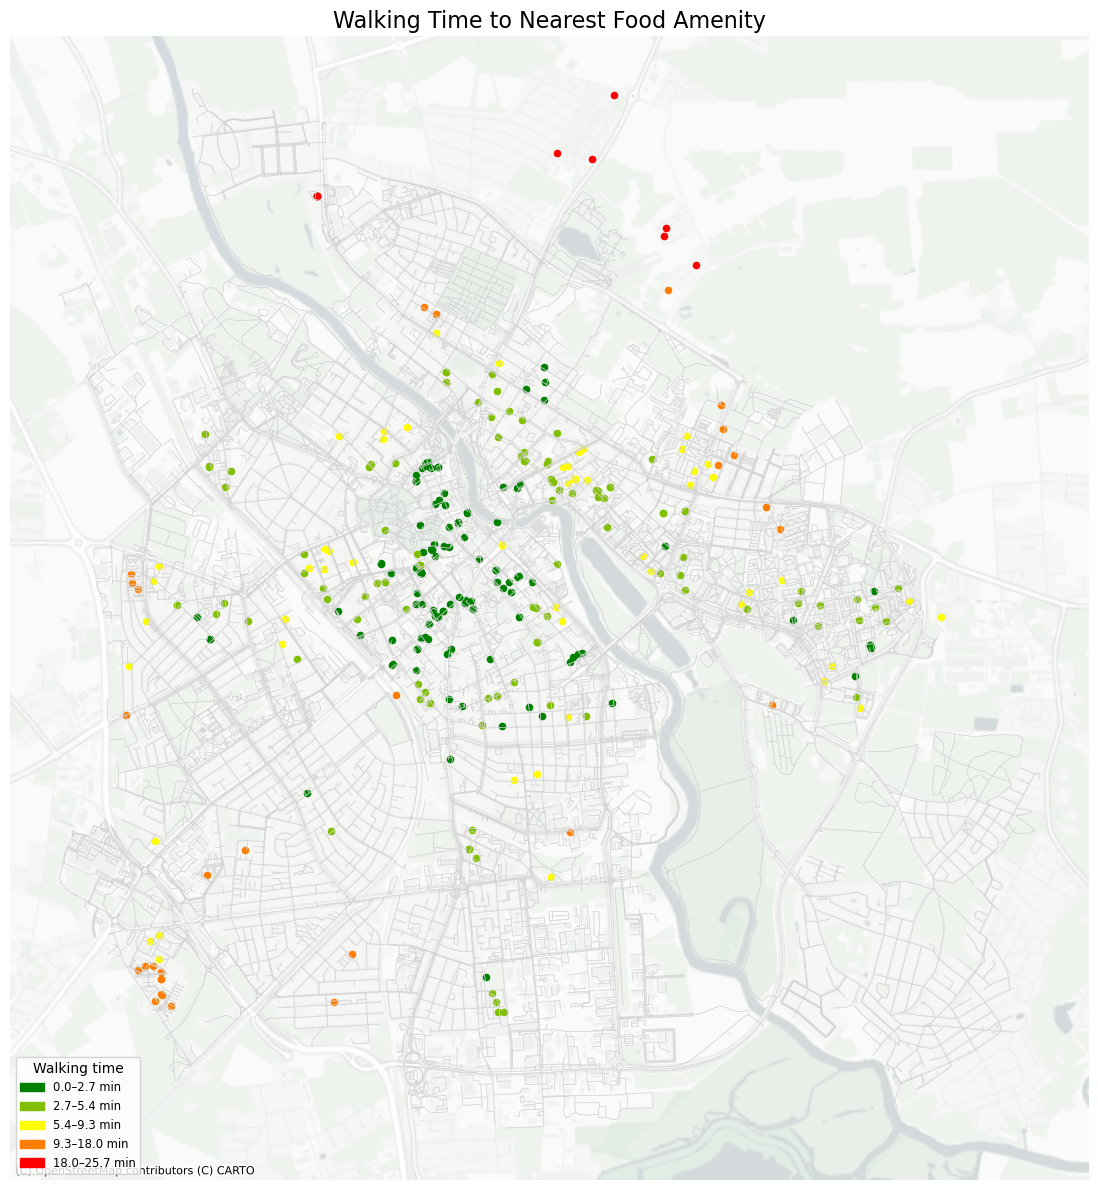

In [54]:
fig, ax = plt.subplots(figsize=(12, 12))


for class_id in range(5):
    class_mask = gdf_rent['walk_time_class'] == class_id
    gdf_rent[class_mask].plot(ax=ax, color=colors[class_id], markersize=20, label=f"{nb.bins[class_id - 1] if class_id > 0 else 0:.1f}–{nb.bins[class_id]:.1f} min")

edges.plot(ax=ax, linewidth=0.5, color='lightgray', alpha=0.7)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_rent.crs)

handles = [mpatches.Patch(color=colors[i], label=f"{nb.bins[i - 1] if i > 0 else 0:.1f}–{nb.bins[i]:.1f} min") for i in range(5)]
ax.legend(handles=handles, title="Walking time", loc='lower left', fontsize='small', title_fontsize='medium', frameon=True)

# Final tweaks
ax.set_title("Walking Time to Nearest Food Amenity", fontsize=16)
ax.axis('off')
plt.tight_layout()

plt.savefig("walking_time_to_food.png", dpi=300, bbox_inches='tight')

plt.show()

In [55]:
# Loendan millise korteri juures on kõige rokem teenuseid 10 min jalutuskäigu kaugusel

In [56]:
all_amenities = []
for group, types in amenity_groups.items():
    pois = pois_all[pois_all['amenity'].isin(types)]
    pois = pois[pois.geometry.type == 'Point'].copy()
    all_amenities.append(pois)

In [57]:
combined_pois = gpd.GeoDataFrame(pd.concat(all_amenities, ignore_index=True), crs=pois_all.crs)

In [58]:
combined_pois['node'] = combined_pois.geometry.progress_apply(lambda x: ox.distance.nearest_nodes(G, x.x, x.y))

100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [01:04<00:00, 10.07it/s]


In [59]:
all_amenity_nodes = combined_pois['node'].tolist()

In [60]:
def count_amenities_within_radius(node, amenity_nodes, radius=800):
    ego = ego_graph(G, node, radius=radius, distance='length')
    return sum(n in amenity_nodes for n in ego.nodes)

In [61]:
gdf_rent['amenity_count_800m'] = gdf_rent['nearest_node'].progress_apply(
    lambda n: count_amenities_within_radius(n, all_amenity_nodes)
)

100%|████████████████████████████████████████████████████████████████████████████████| 331/331 [00:10<00:00, 32.08it/s]


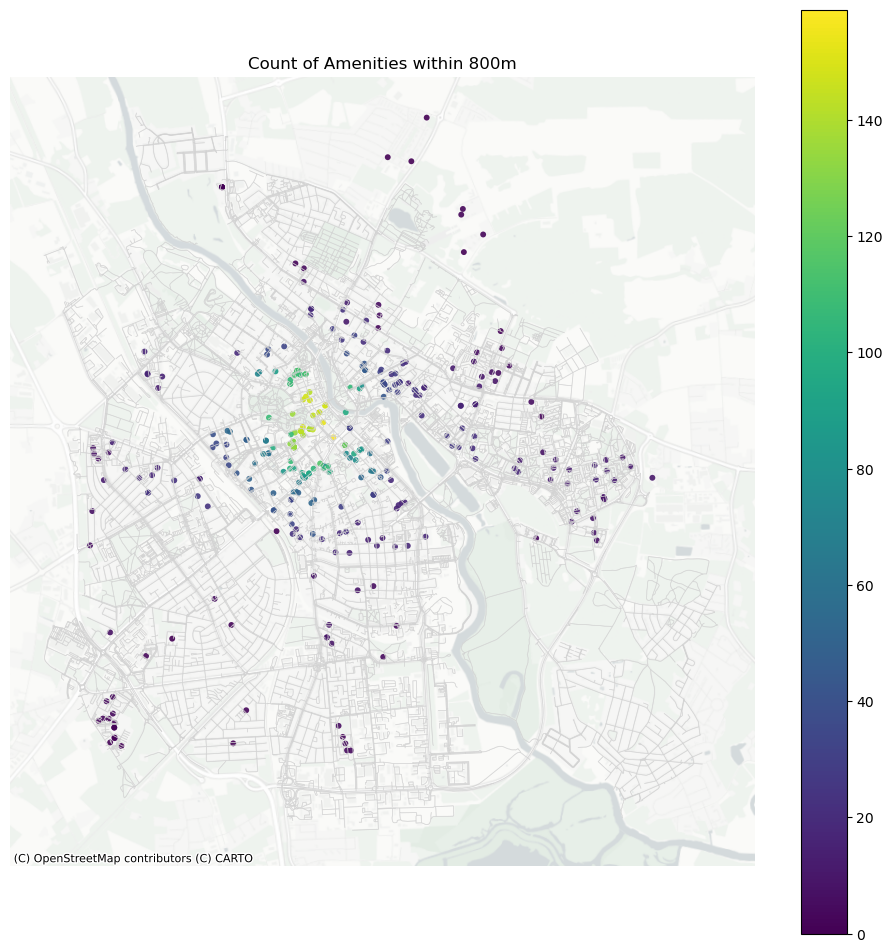

In [62]:
fig, ax = plt.subplots(figsize=(12, 12))

edges.plot(ax=ax, linewidth=0.5, color='lightgray', alpha=0.7)

gdf_rent.plot(
    ax=ax,
    column='amenity_count_800m',
    cmap='viridis',
    legend=True,
    markersize=18,
    alpha=0.9,
    edgecolor='none'  
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_rent.crs)

plt.title("Count of Amenities within 800m")
plt.axis('off')
plt.show()

In [63]:
# see kukkus natuke tühiselt välja

In [64]:
from collections import defaultdict

In [65]:
WALK_RADIUS = 800

In [66]:
group_node_map = defaultdict(set)

for group, types in amenity_groups.items():
    pois = pois_all[pois_all['amenity'].isin(types)]
    pois = pois[pois.geometry.type == 'Point'].copy()
    
    if pois.empty:
        continue
    
    pois['node'] = pois.geometry.progress_apply(lambda x: ox.distance.nearest_nodes(G, x.x, x.y))
    group_node_map[group] = set(pois['node'])

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.73it/s]


In [67]:
def count_diverse_amenities(node, group_node_map, radius=WALK_RADIUS):
    reachable = ego_graph(G, node, radius=radius, distance='length')
    reachable_nodes = set(reachable.nodes)
    
    present_groups = [group for group, nodes in group_node_map.items() if reachable_nodes & nodes]
    return len(present_groups)

In [68]:
gdf_rent['amenity_diversity_score'] = gdf_rent['nearest_node'].progress_apply(
    lambda n: count_diverse_amenities(n, group_node_map)
)

100%|████████████████████████████████████████████████████████████████████████████████| 331/331 [00:08<00:00, 39.46it/s]


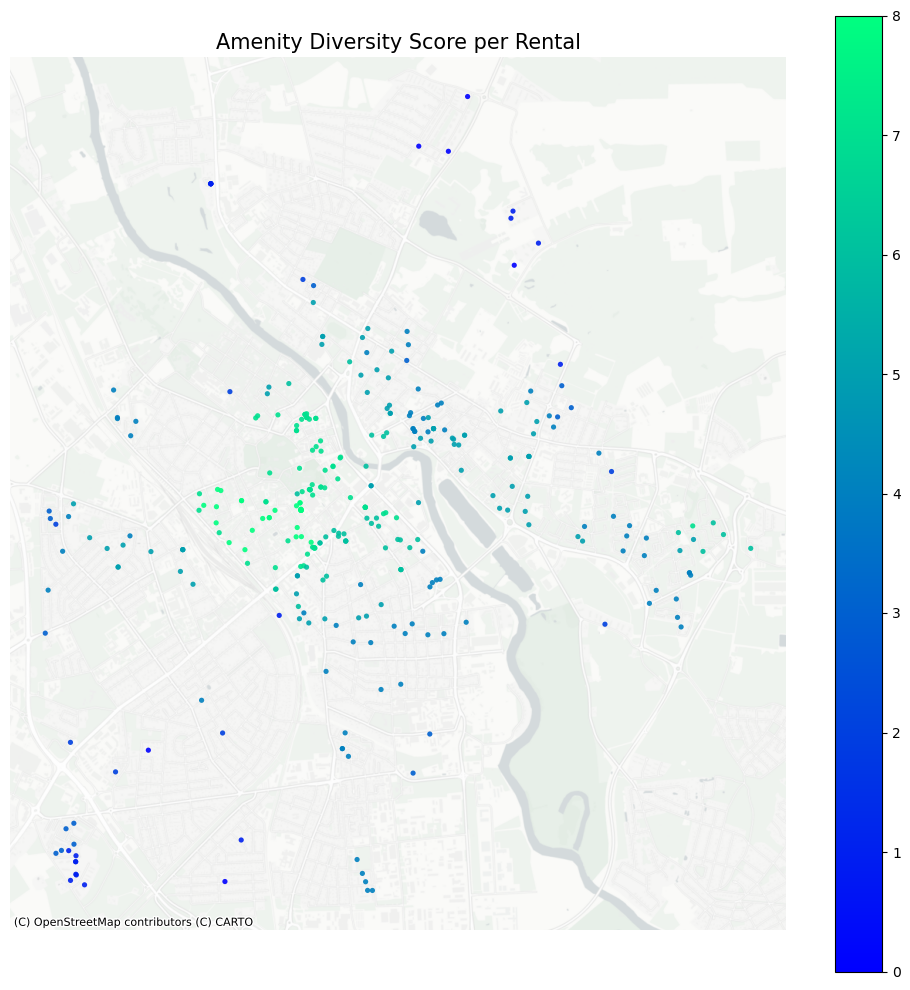

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_rent.plot(
    ax=ax,
    column='amenity_diversity_score',
    cmap='winter',
    legend=True,
    markersize=14,
    alpha=0.9,
    edgecolor='none'
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.PositronNoLabels,
    crs=gdf_rent.crs,
    zoom=14
)

ax.set_title("Amenity Diversity Score per Rental", fontsize=15)
ax.axis('off')

plt.tight_layout()

plt.savefig("amenity_diversity_score.png", dpi=300, bbox_inches='tight')

plt.show()

In [70]:
# Kesklinn tuleb ikkagi esile aga samas on näha et kesklinna ümbrus on "parem" kui kesklinn ise. Samuti tuleb esile Annelinn